# 07 - Model Evaluation

Avaliação final com hold-out, métricas (RMSE, MAE, R2), curva de resíduos e feature importance.



✅ Dados processados carregados do HF Hub
{'rmse': np.float64(0.7040603310476325), 'mae': 0.5420465686274509, 'r2': 0.4235590933858663}


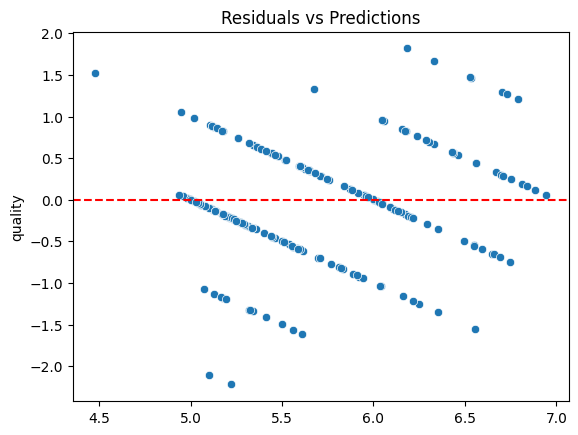

alcohol                 0.277915
sulphates               0.146438
volatile acidity        0.141449
chlorides               0.077495
total sulfur dioxide    0.074758
pH                      0.063146
density                 0.059272
free sulfur dioxide     0.056878
fixed acidity           0.056834
citric acid             0.045814
dtype: float64

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from huggingface_hub import hf_hub_download
from pathlib import Path

# helpers

def load_selected_features(df: pd.DataFrame) -> list:
    p = Path('reports/eda/selected_features.csv')
    if p.exists():
        try:
            feats = pd.read_csv(p).iloc[:,0].dropna().astype(str).tolist()
            feats = [c for c in feats if c in df.columns and c != 'quality']
            if feats:
                return feats
        except Exception:
            pass
    return [c for c in df.select_dtypes(include=[np.number]).columns if c != 'quality']


def load_processed_df():
    HF_TOKEN = os.getenv('HF_TOKEN', None)
    HF_PROCESSED_REPO = os.getenv('HF_PROCESSED_REPO', 'henriquebap/wine-ml-processed')
    try:
        df_path = hf_hub_download(repo_id=HF_PROCESSED_REPO, filename='processed/full.csv', repo_type='dataset', token=HF_TOKEN)
        df = pd.read_csv(df_path)
        print('✅ Dados processados carregados do HF Hub')
    except Exception as e:
        print('⚠️ Fallback para dados locais:', e)
        proc = Path.cwd().parent / 'data' / 'processed' / 'df_capped.csv'
        if proc.exists():
            df = pd.read_csv(proc)
        else:
            raise FileNotFoundError('df_capped.csv não encontrado localmente nem no Hub')
    return df

_df = load_processed_df()
FEATURES = load_selected_features(_df)
X = _df[FEATURES]
y = _df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
# Compute RMSE manually to avoid the 'squared' argument error
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print({"rmse": rmse, "mae": mae, "r2": r2})

# Residuals plot
resid = y_test - pred
sns.scatterplot(x=pred, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predictions')
plt.show()

# Feature importance
importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
importances


In [3]:
# Exporta modelo final e metadados
from pathlib import Path
import joblib

models_dir = Path.cwd().parent / 'data' / 'models'
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / 'wine_quality_regressor.joblib'
meta = {
    'features': FEATURES,
    'model_class': type(model).__name__,
    'metrics': {'rmse': float(rmse), 'mae': float(mae), 'r2': float(r2)}
}

joblib.dump({'model': model, 'metadata': meta}, model_path)
print('✅ Modelo salvo em:', model_path)
meta


✅ Modelo salvo em: /Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/data/models/wine_quality_regressor.joblib


{'features': ['alcohol',
  'volatile acidity',
  'sulphates',
  'citric acid',
  'chlorides',
  'density',
  'fixed acidity',
  'total sulfur dioxide',
  'pH',
  'free sulfur dioxide'],
 'model_class': 'RandomForestRegressor',
 'metrics': {'rmse': 0.7040603310476325,
  'mae': 0.5420465686274509,
  'r2': 0.4235590933858663}}